## la préparation des données et le feature engineering : 

### https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features

### 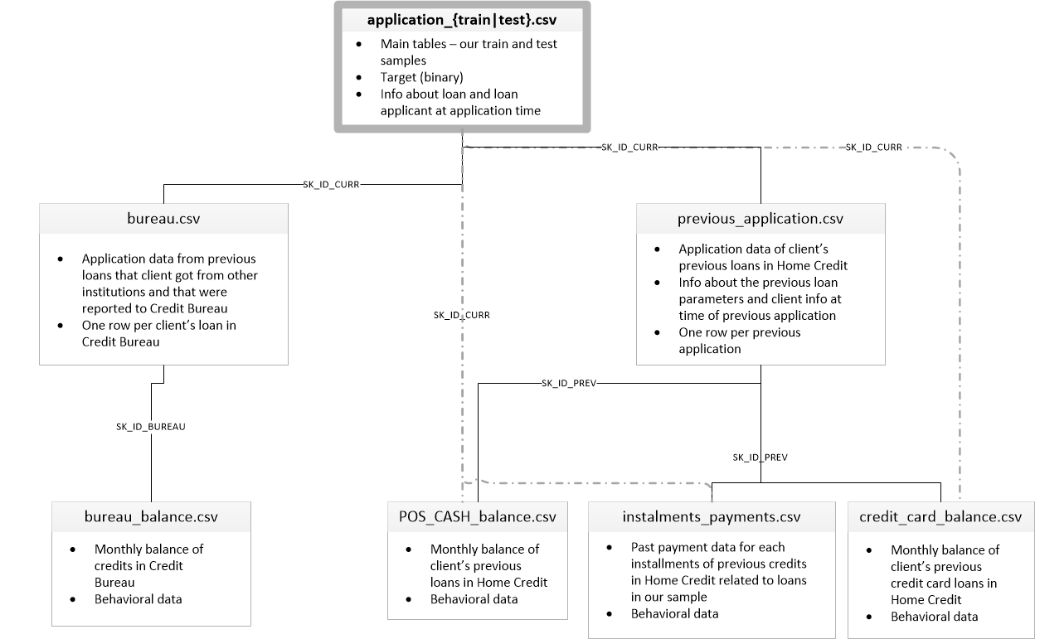

### Je souhaite que vous puissiez mettre en oeuvre au minimum les étapes orientées MLOps suivantes : 

Dans le notebook d’entraînement des modèles, générer à l’aide de MLFlow un tracking d'expérimentations. 
Lancer l’interface web 'UI MLFlow" d'affichage des résultats du tracking. 
Réaliser avec MLFlow un stockage centralisé des modèles dans un “model registry”. 
Tester le serving MLFlow. 
Gérer le code avec le logiciel de version Git. 
Partager le code sur Github pour assurer une intégration continue. 
Utiliser Github Actions pour le déploiement continu et automatisé du code de l’API sur le cloud. 
Concevoir des tests unitaires avec Pytest (ou Unittest) et les exécuter de manière automatisée lors du build réalisé par Github Actions

## Feature engineering

#### Option 1 
https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script

In [132]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
# from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
# from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    train_path = r"C:\Users\BNP\0 - OC - Formation Datascientist\3 - Projet\Projet 7\application_train.csv"
    test_path = r"C:\Users\BNP\0 - OC - Formation Datascientist\3 - Projet\Projet 7\application_test.csv"
    df = pd.read_csv(train_path, nrows=num_rows)
    test_df = pd.read_csv(test_path, nrows=num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    # df = df.append(test_df).reset_index()
    df = pd.concat([df, test_df]).reset_index(drop=True)
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau_path = r"C:\Users\BNP\0 - OC - Formation Datascientist\3 - Projet\Projet 7\bureau.csv"
    bureau = pd.read_csv(bureau_path, nrows=num_rows)
    bb_path = r"C:\Users\BNP\0 - OC - Formation Datascientist\3 - Projet\Projet 7\bureau_balance.csv"
    bb = pd.read_csv(bb_path, nrows=num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev_path = r"C:\Users\BNP\0 - OC - Formation Datascientist\3 - Projet\Projet 7\previous_application.csv"
    prev = pd.read_csv(prev_path, nrows=num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos_path = r"C:\Users\BNP\0 - OC - Formation Datascientist\3 - Projet\Projet 7\POS_CASH_balance.csv"
    pos = pd.read_csv(pos_path, nrows=num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins_path = r"C:\Users\BNP\0 - OC - Formation Datascientist\3 - Projet\Projet 7\installments_payments.csv"
    ins = pd.read_csv(ins_path, nrows=num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc_path = r"C:\Users\BNP\0 - OC - Formation Datascientist\3 - Projet\Projet 7\credit_card_balance.csv"
    cc = pd.read_csv(cc_path, nrows=num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg


def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    print("Initial df shape:", df.shape)  # Print the shape of df to confirm it's loaded

    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        print("df after joining bureau:", df.shape)
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        print("df after joining previous applications:", df.shape)
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        print("df after joining pos:", df.shape)
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        print("df after joining installments payments:", df.shape)
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        print("df after joining credit card balance:", df.shape)
        del cc
        gc.collect()
    # with timer("Run LightGBM with kfold"):
    #     feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= False, debug= debug)
    return df  # Ajout du retour

if __name__ == "__main__":
    with timer("Full model run"):
        df = main()
    print("Final DataFrame shape:", df.shape)

Train samples: 307511, test samples: 48744
Initial df shape: (356251, 247)
Bureau df shape: (305811, 116)
df after joining bureau: (356251, 363)
Process bureau and bureau_balance - done in 36s
Previous applications df shape: (338857, 249)
df after joining previous applications: (356251, 612)
Process previous_applications - done in 54s
Pos-cash balance df shape: (337252, 18)
df after joining pos: (356251, 630)
Process POS-CASH balance - done in 29s
Installments payments df shape: (339587, 26)
df after joining installments payments: (356251, 656)
Process installments payments - done in 50s
Credit card balance df shape: (103558, 141)
df after joining credit card balance: (356251, 797)
Process credit card balance - done in 41s
Full model run - done in 220s
Final DataFrame shape: (356251, 797)


In [133]:
df.shape

(356251, 797)

In [134]:
df.columns

Index(['SK_ID_CURR', 'TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       ...
       'CC_NAME_CONTRACT_STATUS_Signed_MAX',
       'CC_NAME_CONTRACT_STATUS_Signed_MEAN',
       'CC_NAME_CONTRACT_STATUS_Signed_SUM',
       'CC_NAME_CONTRACT_STATUS_Signed_VAR', 'CC_NAME_CONTRACT_STATUS_nan_MIN',
       'CC_NAME_CONTRACT_STATUS_nan_MAX', 'CC_NAME_CONTRACT_STATUS_nan_MEAN',
       'CC_NAME_CONTRACT_STATUS_nan_SUM', 'CC_NAME_CONTRACT_STATUS_nan_VAR',
       'CC_COUNT'],
      dtype='object', length=797)

### Gestion des inf

In [135]:
df = df.replace([np.inf, -np.inf], np.nan)

### Renommage des features
Les caract-res spéciaux ne sont pas pris en compte

In [136]:
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

#### Suppression des colonnes et lignes NA
On supprimes les colonnes et les lignes avec beaucoup de données manquantes (contiennent plus de 40 % de valeurs manquantes (NaN). )

In [137]:
df.shape

(356251, 797)

In [138]:
# nb de colonnes contenant plus de 40 % de valeurs manquantes (Nan)
(df.isna().mean()>0.4).sum()

245

In [139]:
#  calcule la proportion de valeurs manquantes (NaN) dans la colonne TARGET
df.TARGET.isna().mean()

0.1368248790880587

In [140]:
# Garder uniquement les colonnes qui contiennent au plus 40 % de valeurs manquantes.
df = df.loc[:, df.isna().mean() <= 0.4]

In [141]:
# Supprimer les lignes contenant plus de 40 % de valeurs manquantes
df = df.loc[df.T.isna().mean() <= 0.4, :]

In [142]:
df.shape

(339232, 552)

#### Séparation des données + Imputation des valeurs manquantes + Train/test

In [143]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# 1. Séparation initiale des données
train_df = df[df['TARGET'].notnull()]  # Lignes où TARGET n'est pas null
test_df = df[df['TARGET'].isnull()]    # Lignes où TARGET est null

# 2. Imputation des valeurs manquantes
imputer = SimpleImputer(strategy='median')

# Appliquer l'imputation sur train_df et test_df
train_df.iloc[:, :] = imputer.fit_transform(train_df)
test_df.iloc[:, :] = imputer.transform(test_df)

# 3. Séparer les caractéristiques (X) et la cible (y)
X_train = train_df.drop(columns=['TARGET'])  # Caractéristiques
y_train = train_df['TARGET']                 # Cible

X_test = test_df.drop(columns=['TARGET'])    # Caractéristiques du jeu de test

# 4. Nettoyage de y_train

print("Nombre de NaN dans y_train avant nettoyage :", y_train.isnull().sum())
y_train.fillna(y_train.median(), inplace=True)  # Remplacer les NaN par la médiane
assert not y_train.isnull().any(), "y_train contient encore des NaN après le nettoyage."

# 5. Diviser les données d'entraînement en sous-jeux (entraînement/validation)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=5, stratify=y_train
)

y_train.fillna(y_train.median(), inplace=True)


# 5. Vérifications
print("Taille de X_train :", X_train.shape)
print("Taille de y_train :", y_train.shape)
print("Taille de X_val :", X_val.shape)
print("Taille de y_val :", y_val.shape)
print("Taille de X_test :", X_test.shape)


Nombre de NaN dans y_train avant nettoyage : 0


C:\Users\BNP\AppData\Local\Temp\ipykernel_10592\2544342348.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train.fillna(y_train.median(), inplace=True)  # Remplacer les NaN par la médiane


Taille de X_train : (203963, 551)
Taille de y_train : (203963,)
Taille de X_val : (87414, 551)
Taille de y_val : (87414,)
Taille de X_test : (47855, 551)


In [144]:
# test_df.drop('TARGET', axis='columns', inplace=True)

### Entraînement et suivi avec MLFlow : Exemple avec un modèle RandomForest

### Mise en place de MLFlow pour le tracking des experimentations

In [145]:
pip install mlflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Le code permet de suivre tout le cycle d'une expérimentation avec MLFlow, notamment :

Les hyperparamètres utilisés pour configurer le modèle.
Les métriques de performance pour évaluer le modèle.
Le modèle lui-même pour être réutilisé ultérieurement.

In [146]:
import mlflow
mlflow.set_tracking_uri("http://localhost:5001")

#### Démarrez l'interface MLFlow en bash en mettant le code
mlflow server --host 0.0.0.0 --port 5001

ouvrir une page web avec http://localhost:5001


In [147]:
pip install lightgbm


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Modèles

In [148]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score 
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, cross_validate
from sklearn.feature_selection import RFECV
from sklearn.metrics import precision_recall_fscore_support

from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import time

In [149]:
def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba):
    '''This function will make a pretty plot of 
  an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.'''
    fig = plt.figure(figsize=(20,15))
  
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    #show()

In [150]:
def business_scorer(y, y_pred) : 
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    error = 10*fn + fp
    return -error

In [151]:
scoring = {'business_scorer': make_scorer(business_scorer, greater_is_better=True),  'auc': 'roc_auc'}

### Paramètres des modèles à utiliser

In [152]:
param_grid_dm = {'dummyclassifier__strategy' : ['most_frequent', 'prior', 'stratified', 'uniform', 'constant'], 
              'dummyclassifier__constant' : [1]
             }  

param_grid_lc = {'logisticregression__C': [0.1, 1.0, 10.0], 
                 'logisticregression__penalty': ['l2'],
                 'logisticregression__solver': ["lbfgs"]
             }  

param_grid_rfc = {'randomforestclassifier__n_estimators': [50, 100], # Réduire le nombre d'arbres
              'randomforestclassifier__min_samples_leaf' : [5], # Augmenter pour limiter la taille des feuilles
              'randomforestclassifier__min_samples_split' : [5], # Augmenter pour réduire la complexité des arbres
              'randomforestclassifier__max_samples': [0.5],  # Utilise 50 % ou 80 % des données pour chaque arbre
              'randomforestclassifier__max_depth' : [5, 10]  # Limiter la profondeur des arbres
             }  


param_grid_lgbm = {'lgbmclassifier__learning_rate': [0.05, 0.1], 
                   'lgbmclassifier__max_depth': [5, 6, 7], 
                   'lgbmclassifier__n_estimators':[50, 100],
                   'lgbmclassifier__is_unbalance': [True, False]
            }

### Les modèles à utiliser

In [153]:
dc = DummyClassifier(random_state=5)
lr = LogisticRegression(random_state=5)
rfc = RandomForestClassifier(random_state=5)
lgbmc = LGBMClassifier(random_state=5, boosting_type = 'goss', objective = 'binary')

#### Fonction qui sélectionne le modèle ayant le meilleur AUC (Area Under Curve) en fonction de son rang, puis extrait :

Son score métier moyen.
Son score AUC moyen.
Le temps moyen qu'il a pris pour s'ajuster (entraîner).
Cela permet de comparer les modèles de manière pratique en fonction de plusieurs critères

In [154]:
def get_scores_and_fitting_time(results) :
    best_cv = results['rank_test_auc'].argmin()
    best_business = results['mean_test_business_scorer'][best_cv]
    best_auc = results['mean_test_auc'][best_cv]
    best_time_fitting = results['mean_fit_time'][best_cv]
    
    return best_business, best_auc, best_time_fitting

In [155]:
X.shape

(339232, 551)

In [156]:
#sc = StandardScaler()
scaler = MinMaxScaler(feature_range = (0, 1))

In [157]:
y.shape

(339232,)

### données utilisées sans oversampling ni undersampling

#### Dummy Classifier (testé avec train/test)

In [158]:
%%time

with mlflow.start_run(run_name='dummy'):

    pipeline = make_pipeline(scaler, dc)  

    grid_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_grid_dm, cv=5, scoring=scoring, refit='business_scorer', return_train_score=True)  
    grid_search.fit(X_train, y_train)  
    results = grid_search.cv_results_
    best_business_dc, best_auc_dc, best_time_fitting_dc = get_scores_and_fitting_time(results)
    best_params_dc = grid_search.best_params_  
    
    #best_score_dc = grid_search.best_score_  
    #cf_matrix_roc_auc(grid_search.best_estimator_, data_train_reduit.TARGET, grid_search.best_estimator_.predict(data_train_reduit.drop('TARGET', axis=1)), grid_search.best_estimator_.predict_proba(data_train_reduit.drop('TARGET', axis=1))[:,1])
    #print(classification_report(data_train_reduit.TARGET, grid_search.best_estimator_.predict(data_train_reduit.drop('TARGET', axis=1))))
    
    print("Meilleurs params :", best_params_dc)
    print("Meilleur business score :", best_business_dc)
    print("AUC :", best_auc_dc)
    print("Fitting time", best_time_fitting_dc)
    
    for param_name in best_params_dc:
        mlflow.log_param(param_name, best_params_dc[param_name])
    
    mlflow.log_metric("Business score", best_business_dc)
    mlflow.log_metric('AUC', best_auc_dc)
    mlflow.log_metric('Fit time', best_time_fitting_dc)
    mlflow.sklearn.log_model(grid_search.best_estimator_, "best_model")
    
    mlflow.end_run()

C:\Users\BNP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Meilleurs params : {'dummyclassifier__strategy': 'most_frequent', 'dummyclassifier__constant': 1}
Meilleur business score : -33571.6
AUC : 0.5026834781009589
Fitting time 2.4723891735076906


2025/01/12 17:02:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run dummy at: http://localhost:5001/#/experiments/0/runs/5e2258c9f4494a6cad4ea12132998796
🧪 View experiment at: http://localhost:5001/#/experiments/0
CPU times: total: 2min 26s
Wall time: 2min 39s


### Regression logistique

In [159]:
%%time

with mlflow.start_run(run_name='Logistic regression'):

    pipeline = make_pipeline(scaler, lr)  

    grid_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_grid_lc, cv=5, scoring=scoring, refit='business_scorer', return_train_score=True)  
    grid_search.fit(X_train, y_train)  
    results = grid_search.cv_results_
    best_business_lr, best_auc_lr, best_time_fitting_lr = get_scores_and_fitting_time(results)
    best_params_lr = grid_search.best_params_  
    
    print("Meilleurs params :", best_params_lr)
    print("Meilleur business score :", best_business_lr)
    print("AUC :", best_auc_lr)
    print("Fitting time", best_time_fitting_lr)
    
    for param_name in best_params_lr:
        mlflow.log_param(param_name, best_params_lr[param_name])
    
    mlflow.log_metric("Business score", best_business_lr)
    mlflow.log_metric('AUC', best_auc_lr)
    mlflow.log_metric('Fit time', best_time_fitting_lr)
    mlflow.sklearn.log_model(grid_search.best_estimator_, "best_model")
    
    mlflow.end_run()

C:\Users\BNP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\BNP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\BNP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATI

Meilleurs params : {'logisticregression__solver': 'lbfgs', 'logisticregression__penalty': 'l2', 'logisticregression__C': 10.0}
Meilleur business score : -32707.8
AUC : 0.7598034986851381
Fitting time 27.472051429748536


2025/01/12 17:11:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Logistic regression at: http://localhost:5001/#/experiments/0/runs/d55a99e385544398a10c1a807b3277ba
🧪 View experiment at: http://localhost:5001/#/experiments/0
CPU times: total: 19min 51s
Wall time: 8min 26s


### LGBMClassifier

In [160]:
%%time

with mlflow.start_run(run_name='LGBM'):
    
    pipeline = make_pipeline(scaler, lgbmc)  

    grid_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_grid_lgbm, cv=5, scoring=scoring, refit='business_scorer', return_train_score=True)  
    grid_search.fit(X_train, y_train)  
    results = grid_search.cv_results_
    best_business_lgbmc, best_auc_lgbmc, best_time_fitting_lgbmc = get_scores_and_fitting_time(results)
    best_params_lgbmc = grid_search.best_params_  
    
    print("Meilleurs params :", best_params_lgbmc)
    print("Meilleur business score :", best_business_lgbmc)
    print("AUC :", best_auc_lgbmc)
    print("Fitting time", best_time_fitting_lgbmc)
    
    for param_name in best_params_lgbmc:
        mlflow.log_param(param_name, best_params_lgbmc[param_name])
    
    mlflow.log_metric("Business score", best_business_lgbmc)
    mlflow.log_metric('AUC', best_auc_lgbmc)
    mlflow.log_metric('Fit time', best_time_fitting_lgbmc)
    mlflow.sklearn.log_model(grid_search.best_estimator_, "best_model")
    mlflow.end_run()

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 13370, number of negative: 149800
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.060497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55355
[LightGBM] [Info] Number of data points in the train set: 163170, number of used features: 506
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081939 -> initscore=-2.416288
[LightGBM] [Info] Start training from score -2.416288
[LightGBM] [Warning] No further splits with pos

2025/01/12 17:35:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LGBM at: http://localhost:5001/#/experiments/0/runs/60d7fce95bc841ef82905258a616ba26
🧪 View experiment at: http://localhost:5001/#/experiments/0
CPU times: total: 37min 39s
Wall time: 23min 53s


### Random Forest Classifier

In [161]:
%%time

with mlflow.start_run(run_name='Random Forest'):

    pipeline = make_pipeline(scaler, rfc)  

    grid_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_grid_rfc, cv=5, scoring=scoring, refit='business_scorer', return_train_score=True)  
    grid_search.fit(X_train, y_train)  
    results = grid_search.cv_results_
    best_business_rfc, best_auc_rfc, best_time_fitting_rfc = get_scores_and_fitting_time(results)
    best_params_rfc = grid_search.best_params_  
    
    print("Meilleurs params :", best_params_rfc)
    print("Meilleur business score :", best_business_rfc)
    print("AUC :", best_auc_rfc)
    print("Fitting time", best_time_fitting_rfc)
    
    for param_name in best_params_rfc:
        mlflow.log_param(param_name, best_params_rfc[param_name])
    
    mlflow.log_metric("Business score", best_business_rfc)
    mlflow.log_metric('AUC', best_auc_rfc)
    mlflow.log_metric('Fit time', best_time_fitting_rfc)
    mlflow.sklearn.log_model(grid_search.best_estimator_, "best_model")
    
    mlflow.end_run()

C:\Users\BNP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Meilleurs params : {'randomforestclassifier__n_estimators': 50, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__min_samples_leaf': 5, 'randomforestclassifier__max_samples': 0.5, 'randomforestclassifier__max_depth': 5}
Meilleur business score : -33424.0
AUC : 0.7386945588867782
Fitting time 89.66940779685974


2025/01/12 17:56:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Random Forest at: http://localhost:5001/#/experiments/0/runs/6a6e61e7dccc4fdb83eb62deb2510f64
🧪 View experiment at: http://localhost:5001/#/experiments/0
CPU times: total: 20min 32s
Wall time: 20min 48s


### Comparaison des meilleurs modèles

In [162]:
best_business = [best_business_dc, best_business_lr, best_business_rfc, best_business_lgbmc]
best_auc = [best_auc_dc, best_auc_lr, best_auc_rfc, best_auc_lgbmc]
best_time = [best_time_fitting_dc, best_time_fitting_lr, best_time_fitting_rfc, best_time_fitting_lgbmc]

In [163]:
best_df = pd.DataFrame(list(zip(best_business, best_auc, best_time)), columns= ['Business Score', 'AUC', 'Fitting time'], index=['Dummy', 'LogisticRegression', 'RandomForest', 'LGBM'])

In [164]:
best_df

,Business Score,AUC,Fitting time
Dummy,-33571.6,0.502683,2.472389
LogisticRegression,-32707.8,0.759803,27.472051
RandomForest,-33424.0,0.738695,89.669408
LGBM,-20842.4,0.773829,24.529469


In [165]:
best_df['Business Score']

Dummy                -33571.6
LogisticRegression   -32707.8
RandomForest         -33424.0
LGBM                 -20842.4
Name: Business Score, dtype: float64

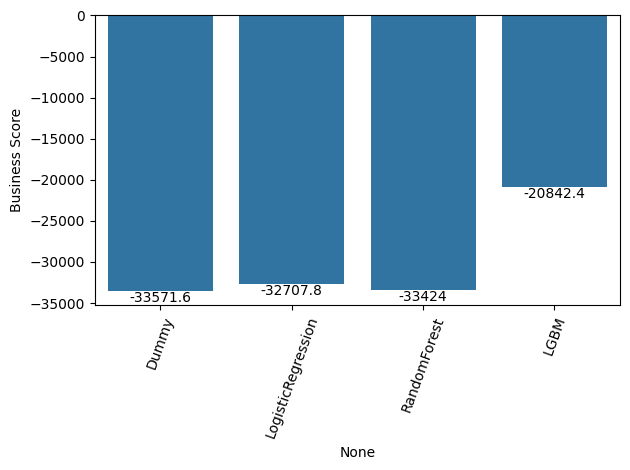

In [166]:
ax = sns.barplot(y='Business Score', x=best_df.index, data=best_df)
ax.bar_label(ax.containers[0], fontsize=10)
plt.xticks(rotation=70)
plt.tight_layout()

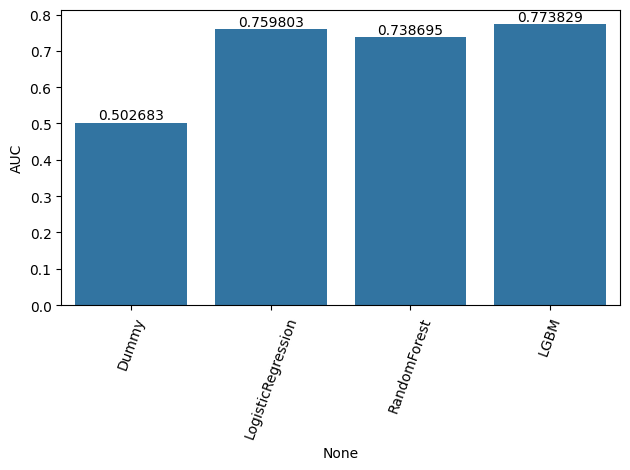

In [167]:
ax = sns.barplot(y='AUC', x=best_df.index, data=best_df)
ax.bar_label(ax.containers[0], fontsize=10)
plt.xticks(rotation=70)
plt.tight_layout()

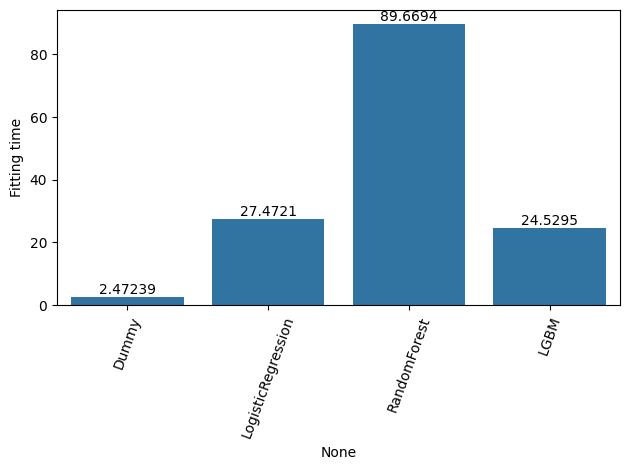

In [168]:
ax = sns.barplot(y='Fitting time', x=best_df.index, data=best_df)
ax.bar_label(ax.containers[0], fontsize=10)
plt.xticks(rotation=70)
plt.tight_layout()

### Undersampling

In [172]:
from imblearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline as make_imb_pipeline 
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

In [173]:
# Create the undersampler
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=5)

#### Dummy Classifier

In [174]:
%%time

with mlflow.start_run(run_name='dummy_with_undersampling'):

    pipeline = make_imb_pipeline(undersampler, scaler, dc)  

    grid_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_grid_dm, cv=5, scoring=scoring, refit='business_scorer', return_train_score=True)  
    grid_search.fit(X_train, y_train)  
    results = grid_search.cv_results_
    best_business_dc_underS, best_auc_dc_underS, best_time_fitting_dc_underS = get_scores_and_fitting_time(results)
    best_params_dc_underS = grid_search.best_params_  
    
    #best_score_dc = grid_search.best_score_  
    #cf_matrix_roc_auc(grid_search.best_estimator_, data_train_reduit.TARGET, grid_search.best_estimator_.predict(data_train_reduit.drop('TARGET', axis=1)), grid_search.best_estimator_.predict_proba(data_train_reduit.drop('TARGET', axis=1))[:,1])
    #print(classification_report(data_train_reduit.TARGET, grid_search.best_estimator_.predict(data_train_reduit.drop('TARGET', axis=1))))
    
    print("Meilleurs params :", best_params_dc_underS)
    print("Meilleur business score :", best_business_dc_underS)
    print("AUC :", best_auc_dc_underS)
    print("Fitting time", best_time_fitting_dc_underS)
    
    for param_name in best_params_dc_underS:
        mlflow.log_param(param_name, best_params_dc_underS[param_name])
    
    mlflow.log_metric("Business score", best_business_dc_underS)
    mlflow.log_metric('AUC', best_auc_dc_underS)
    mlflow.log_metric('Fit time', best_time_fitting_dc_underS)
    mlflow.sklearn.log_model(grid_search.best_estimator_, "best_model")
    
    mlflow.end_run()

C:\Users\BNP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Meilleurs params : {'dummyclassifier__strategy': 'most_frequent', 'dummyclassifier__constant': 1}
Meilleur business score : -33424.0
AUC : 0.5
Fitting time 1.3518183708190918


2025/01/12 18:00:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run dummy_with_undersampling at: http://localhost:5001/#/experiments/0/runs/798a560a297344d48d71f2750099ea32
🧪 View experiment at: http://localhost:5001/#/experiments/0
CPU times: total: 1min 57s
Wall time: 2min 6s


### Logistic regression

In [176]:
%%time

with mlflow.start_run(run_name='Logistic regression_with_undersampling'):

    pipeline = make_imb_pipeline(undersampler, scaler, lr)   

    grid_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_grid_lc, cv=5, scoring=scoring, refit='business_scorer', return_train_score=True)  
    grid_search.fit(X_train, y_train)  
    results = grid_search.cv_results_
    best_business_lr_underS, best_auc_lr_underS, best_time_fitting_lr_underS = get_scores_and_fitting_time(results)
    best_params_lr_underS = grid_search.best_params_  
    
    print("Meilleurs params :", best_params_lr_underS)
    print("Meilleur business score :", best_business_lr_underS)
    print("AUC :", best_auc_lr_underS)
    print("Fitting time", best_time_fitting_lr_underS)
    
    for param_name in best_params_lr_underS:
        mlflow.log_param(param_name, best_params_lr_underS[param_name])
    
    mlflow.log_metric("Business score", best_business_lr_underS)
    mlflow.log_metric('AUC', best_auc_lr_underS)
    mlflow.log_metric('Fit time', best_time_fitting_lr_underS)
    mlflow.sklearn.log_model(grid_search.best_estimator_, "best_model")
    
    mlflow.end_run()

C:\Users\BNP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\BNP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\BNP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATI

Meilleurs params : {'logisticregression__solver': 'lbfgs', 'logisticregression__penalty': 'l2', 'logisticregression__C': 10.0}
Meilleur business score : -21735.6
AUC : 0.7593588180661481
Fitting time 5.047848176956177


2025/01/12 18:09:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Logistic regression_with_undersampling at: http://localhost:5001/#/experiments/0/runs/69c15087890c4c9cb5f39ecf7703cd3d
🧪 View experiment at: http://localhost:5001/#/experiments/0
CPU times: total: 4min 7s
Wall time: 2min 30s


### LGBM Classifier

In [177]:
%%time

with mlflow.start_run(run_name='LGBM_with_undersampling'):
    
    pipeline = make_imb_pipeline(undersampler, scaler, lgbmc)    

    grid_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_grid_lgbm, cv=5, scoring=scoring, refit='business_scorer', return_train_score=True)  
    grid_search.fit(X_train, y_train)  
    results = grid_search.cv_results_
    best_business_lgbmc_underS, best_auc_lgbmc_underS, best_time_fitting_lgbmc_underS = get_scores_and_fitting_time(results)
    best_params_lgbmc_underS = grid_search.best_params_  
    
    print("Meilleurs params :", best_params_lgbmc_underS)
    print("Meilleur business score :", best_business_lgbmc_underS)
    print("AUC :", best_auc_lgbmc_underS)
    print("Fitting time", best_time_fitting_lgbmc_underS)
    
    for param_name in best_params_lgbmc_underS:
        mlflow.log_param(param_name, best_params_lgbmc_underS[param_name])
    
    mlflow.log_metric("Business score", best_business_lgbmc_underS)
    mlflow.log_metric('AUC', best_auc_lgbmc_underS)
    mlflow.log_metric('Fit time', best_time_fitting_lgbmc_underS)
    mlflow.sklearn.log_model(grid_search.best_estimator_, "best_model")
    mlflow.end_run()

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 13370, number of negative: 13370
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.122930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 49970
[LightGBM] [Info] Number of data points in the train set: 26740, number of used features: 480
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

2025/01/12 18:23:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LGBM_with_undersampling at: http://localhost:5001/#/experiments/0/runs/8a1204845dd146e8a667b4c8e2596be4
🧪 View experiment at: http://localhost:5001/#/experiments/0
CPU times: total: 17min 6s
Wall time: 12min 5s


### RandomForest Classifier AVEC UNDERSAMPLING

In [178]:
%%time

with mlflow.start_run(run_name='Random Forest_with_undersampling'):

    pipeline = make_imb_pipeline(undersampler, scaler, rfc) 

    grid_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_grid_rfc, cv=5, scoring=scoring, refit='business_scorer', return_train_score=True)  
    grid_search.fit(X_train, y_train)  
    results = grid_search.cv_results_
    best_business_rfc_underS, best_auc_rfc_underS, best_time_fitting_rfc_underS = get_scores_and_fitting_time(results)
    best_params_rfc_underS = grid_search.best_params_  
    
    print("Meilleurs params :", best_params_rfc_underS)
    print("Meilleur business score :", best_business_rfc_underS)
    print("AUC :", best_auc_rfc_underS)
    print("Fitting time", best_time_fitting_rfc_underS)
    
    for param_name in best_params_rfc_underS:
        mlflow.log_param(param_name, best_params_rfc_underS[param_name])
    
    mlflow.log_metric("Business score", best_business_rfc_underS)
    mlflow.log_metric('AUC', best_auc_rfc_underS)
    mlflow.log_metric('Fit time', best_time_fitting_rfc_underS)
    mlflow.sklearn.log_model(grid_search.best_estimator_, "best_model")
    
    mlflow.end_run()

C:\Users\BNP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Meilleurs params : {'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__min_samples_leaf': 5, 'randomforestclassifier__max_samples': 0.5, 'randomforestclassifier__max_depth': 10}
Meilleur business score : -22713.0
AUC : 0.7405232823332419
Fitting time 14.87926287651062


2025/01/12 18:31:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Random Forest_with_undersampling at: http://localhost:5001/#/experiments/0/runs/11ca2dd867a04559bd9b28b4a81ee2c0
🧪 View experiment at: http://localhost:5001/#/experiments/0
CPU times: total: 6min 12s
Wall time: 6min 38s


### Comparaison des meilleurs modèles avec undersampling

In [179]:
best_business = [best_business_dc_underS, best_business_lr_underS, best_business_rfc_underS, best_business_lgbmc_underS]
best_auc = [best_auc_dc_underS, best_auc_lr_underS, best_auc_rfc_underS, best_auc_lgbmc_underS]
best_time = [best_time_fitting_dc_underS, best_time_fitting_lr_underS, best_time_fitting_rfc_underS, best_time_fitting_lgbmc_underS]

In [185]:
best_df_underS = pd.DataFrame(list(zip(best_business, best_auc, best_time)), columns= ['Business Score', 'AUC', 'Fitting time'], index=['Dummy', 'LogisticRegression', 'RandomForest','LGBM'])

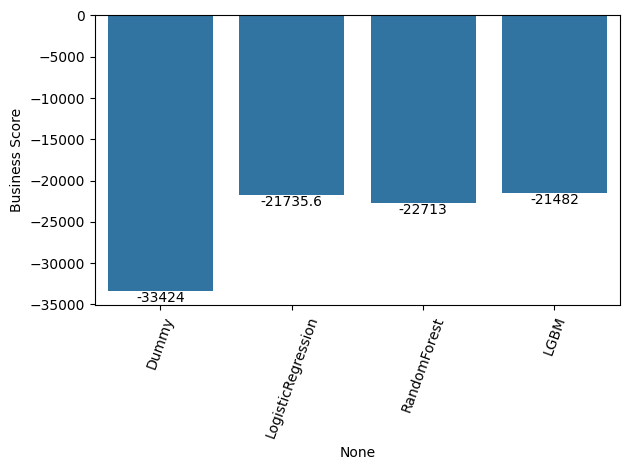

In [186]:
ax = sns.barplot(y='Business Score', x=best_df.index, data=best_df_underS)
ax.bar_label(ax.containers[0], fontsize=10)
plt.xticks(rotation=70)
plt.tight_layout()

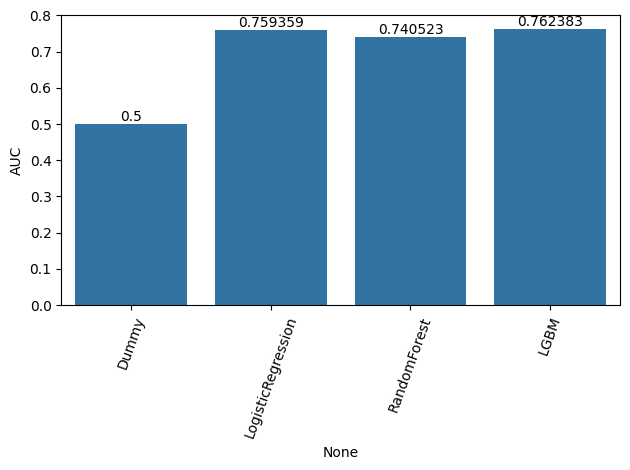

In [187]:
ax = sns.barplot(y='AUC', x=best_df.index, data=best_df_underS)
ax.bar_label(ax.containers[0], fontsize=10)
plt.xticks(rotation=70)
plt.tight_layout()

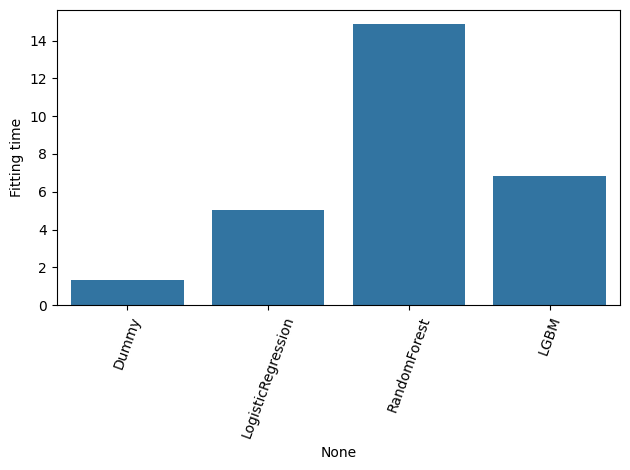

In [189]:
Sax = sns.barplot(y='Fitting time', x=best_df.index, data=best_df_underS)
ax.bar_label(ax.containers[0], fontsize=10)
plt.xticks(rotation=70)
plt.tight_layout()

### Comparaison de tous les modèles

In [191]:
pd_total = pd.concat([best_df, best_df_underS]).reset_index()

In [192]:
pd_total

,index,Business Score,AUC,Fitting time
0,Dummy,-33571.6,0.502683,2.472389
1,LogisticRegression,-32707.8,0.759803,27.472051
2,RandomForest,-33424.0,0.738695,89.669408
3,LGBM,-20842.4,0.773829,24.529469
4,Dummy,-33424.0,0.500000,1.351818
5,LogisticRegression,-21735.6,0.759359,5.047848
6,RandomForest,-22713.0,0.740523,14.879263
7,LGBM,-21482.0,0.762383,6.822997


In [194]:
pd_total['type'] = ['', '', '', '', 'UnderS', 'UnderS', 'UnderS', 'UnderS']

In [195]:
pd_total

,index,Business Score,AUC,Fitting time,type
0,Dummy,-33571.6,0.502683,2.472389,
1,LogisticRegression,-32707.8,0.759803,27.472051,
2,RandomForest,-33424.0,0.738695,89.669408,
3,LGBM,-20842.4,0.773829,24.529469,
4,Dummy,-33424.0,0.500000,1.351818,UnderS
5,LogisticRegression,-21735.6,0.759359,5.047848,UnderS
6,RandomForest,-22713.0,0.740523,14.879263,UnderS
7,LGBM,-21482.0,0.762383,6.822997,UnderS


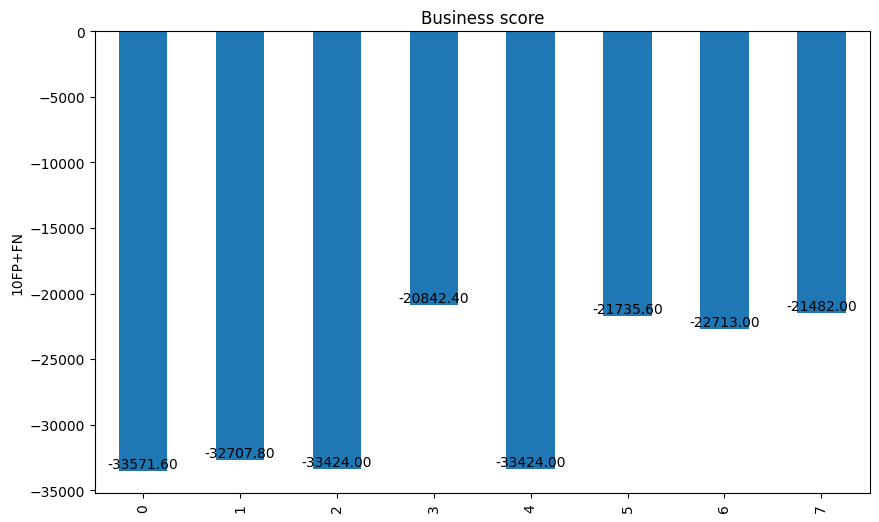

In [198]:
import matplotlib.pyplot as plt

# Tracer le graphique et obtenir l'objet Axes
ax = pd_total['Business Score'].plot(kind='bar', title='Business score', ylabel='10FP+FN', figsize=(10, 6))

# Ajouter des étiquettes au-dessus des barres
for p in ax.patches:  # Parcourt chaque barre
    ax.annotate(f'{p.get_height():.2f}',  # Format de l'étiquette (2 décimales)
                (p.get_x() + p.get_width() / 2, p.get_height()),  # Position (centre de la barre)
                ha='center', va='bottom', fontsize=10)  # Alignement et style

# Afficher le graphique
plt.show()


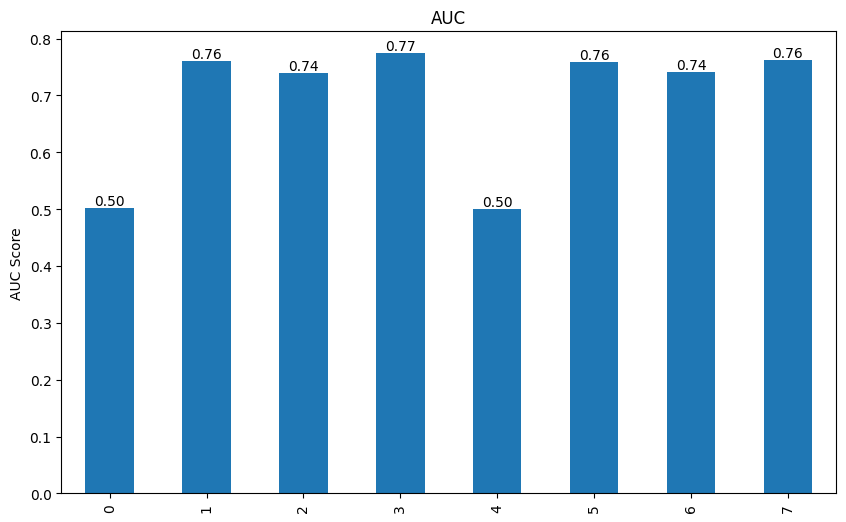

In [200]:
# Tracer le graphique et obtenir l'objet Axes
ax = pd_total['AUC'].plot(kind='bar', title='AUC', figsize=(10, 6), ylabel='AUC Score')

# Ajouter des étiquettes sur chaque barre
for container in ax.containers:  # Parcourt les groupes de barres
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=10)  # Format et style des étiquettes

# Afficher le graphique
plt.show()

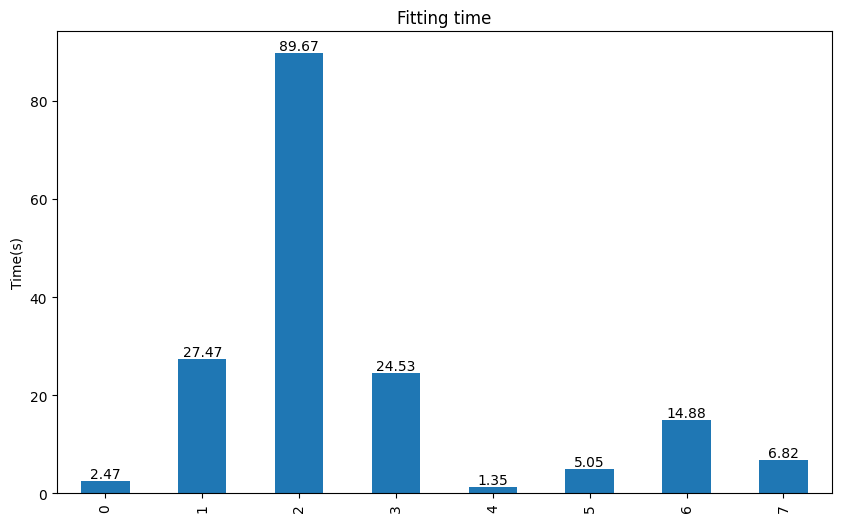

In [201]:
# Tracer le graphique et obtenir l'objet Axes
ax = pd_total['Fitting time'].plot(kind='bar', title='Fitting time', figsize=(10, 6), ylabel='Time(s)')

# Ajouter des étiquettes sur chaque barre
for container in ax.containers:  # Parcourt les groupes de barres
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=10)  # Format et style des étiquettes

# Afficher le graphique
plt.show()

1. Analyse des métriques
Business Score : Une valeur plus élevée (moins négative) est meilleure, car la formule pénalise les faux négatifs (FN) et les faux positifs (FP). L'objectif est de minimiser les erreurs importantes (FN) pour optimiser le score.
AUC (Area Under Curve) : Mesure la capacité du modèle à séparer correctement les classes. Une AUC proche de 1 indique une très bonne performance, tandis qu’une AUC autour de 0.5 signifie une prédiction aléatoire.
Fitting time : Mesure le temps d’entraînement du modèle. Bien qu'il soit important dans certains cas, il est secondaire pour évaluer la qualité d’un modèle.

2. Comparaison entre les modèles
Modèles sans undersampling :
LGBM a le meilleur Business Score (-20,842.4) et la meilleure AUC (0.773829). Il est également plus rapide que RandomForest (89.67 secondes contre 24.52 secondes).
LogisticRegression a une AUC correcte (0.759803), mais son Business Score est moins bon (-32,707.8), et il est plus lent que LGBM.
Modèles avec undersampling :
LGBM (UnderS) a le meilleur Business Score (-21,482.0) et une bonne AUC (0.762383), tout en étant relativement rapide (6.82 secondes).
LogisticRegression (UnderS) suit avec un Business Score de -21,735.6 et une AUC de 0.759359. Cependant, il est plus rapide que LGBM (5.05 secondes).

3. Choix du meilleur modèle
Si on inclut tous les modèles :
Le LGBM sans undersampling est le meilleur modèle globalement, car il combine le meilleur Business Score et la meilleure AUC, avec un temps d'entraînement raisonnable.
Si on privilégie les modèles avec undersampling :
LGBM (UnderS) est le meilleur modèle avec undersampling. Il a le meilleur Business Score et une AUC compétitive, avec un temps d'entraînement plus court que son équivalent sans undersampling.

4. Pourquoi exclure le Dummy Classifier pour tirer le meilleur modèle ?
Le Dummy Classifier est un modèle de référence (baseline) qui ne "réfléchit" pas :

Il utilise des stratégies simples comme prédire systématiquement la classe majoritaire (ou aléatoire, selon la configuration).
Ses performances servent de point de comparaison minimale. Si un modèle performant n'est pas nettement meilleur qu'un Dummy Classifier, cela signifie qu'il ne capture pas les motifs présents dans les données.

### Le meilleur modèle est donc le LGBM sans undersampling

Meilleurs params : {'lgbmclassifier__n_estimators': 100, 'lgbmclassifier__max_depth': 7, 'lgbmclassifier__learning_rate': 0.1, 'lgbmclassifier__is_unbalance': True}
Meilleur business score : -20842.4
AUC : 0.7738288901629475
Fitting time 24.52946858406067

### Seuil de classification

In [208]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import fbeta_score, f1_score
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline 
from sklearn.preprocessing import MinMaxScaler

In [209]:
print(y.isnull().sum())  # Nombre de NaN dans y
print(y.unique())        # Vérifiez les valeurs uniques (NaN pourrait apparaître)

0
[1. 0.]


In [210]:
y.fillna(y.mode()[0], inplace=True)  # Remplace les NaN par la valeur la plus fréquente

In [211]:
# Réindexer X et y pour garantir un RangeIndex
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

# Boucle avec StratifiedKFold
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    print('Fold number {}'.format(i))

    # Utilisez .iloc pour accéder aux données basées sur les positions d'index
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Pipeline et entraînement
    pipeline = make_pipeline(scaler, lgbm_final)
    pipeline.fit(X_train, y_train)
    
    # Reste de votre code...


Fold number 0
[LightGBM] [Info] Number of positive: 19099, number of negative: 252286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.339698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55935
[LightGBM] [Info] Number of data points in the train set: 271385, number of used features: 511
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.070376 -> initscore=-2.580927
[LightGBM] [Info] Start training from score -2.580927
Fold number 1
[LightGBM] [Info] Number of positive: 19099, number of negative: 252286
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.537842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 55944
[LightGBM] [Info] Number of data points in the train set: 271385, number of used features: 512
[LightGBM] [Info] [binary:BoostFromScore]: pav

In [215]:
# Initialize a DataFrame to store business scores
df_business = pd.DataFrame()

skf = StratifiedKFold(n_splits=5)

# Best model (LGBM without undersampling)
lgbm_final = LGBMClassifier(
    n_estimators=100,         # Number of trees
    max_depth=7,              # Best depth found
    learning_rate=0.1,        # Learning rate
    is_unbalance=True         # Account for class imbalance
)

# Loop over the folds
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f'Fold number {i}')

    X_train, X_test = X.loc[train_index, :], X.loc[test_index, :]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    # Create a pipeline with scaler and LGBMClassifier
    pipeline = make_pipeline(scaler, lgbm_final)
    pipeline.fit(X_train, y_train)
    
    # Predictions (probabilities for the positive class)
    y_pred = pipeline.predict_proba(X_test)[:, 1]
    
    business_scores = []  # List to store business scores
    
    # Calculate business scores for different thresholds
    for threshold in np.arange(0.2, 0.8, 0.05):
        # Apply the threshold to the predicted probabilities
        y_pred_binary = (y_pred >= threshold).astype(int)
        
        # Calculate the business score for the current threshold
        score = business_scorer(y_test, y_pred_binary)
        business_scores.append(score)
        
    # Add business scores for this fold
    df_business[f'fold_{i}'] = business_scores  # Store business scores for this fold

# Display final results
print("Business scores across folds:")
print(df_business)

# Find the best threshold (the one with the highest business score)
best_threshold = df_business.mean(axis=1).idxmax() * 0.05 + 0.2
print(f"Best threshold based on business score: {best_threshold}")

Fold number 0
[LightGBM] [Info] Number of positive: 19099, number of negative: 252286
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.567280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 55935
[LightGBM] [Info] Number of data points in the train set: 271385, number of used features: 511
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.070376 -> initscore=-2.580927
[LightGBM] [Info] Start training from score -2.580927
Fold number 1
[LightGBM] [Info] Number of positive: 19099, number of negative: 252286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.474866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55944
[LightGBM] [Info] Number of data points in the train set: 271385, number of used features: 512
[LightGBM] [Info] [binary:BoostFromScore]: pav

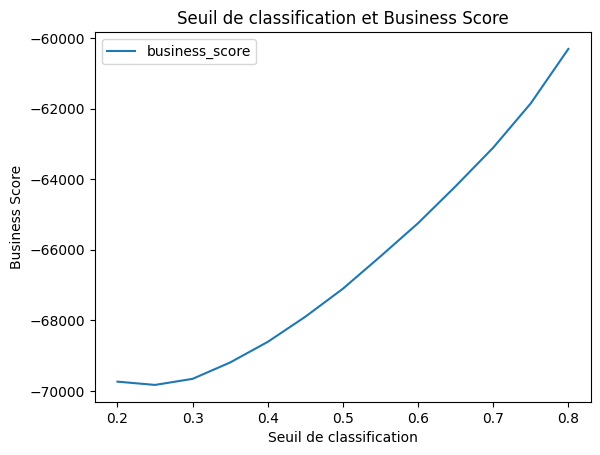

In [216]:
import matplotlib.pyplot as plt

# Assuming df_business contains the business scores across folds, with rows corresponding to different thresholds
# We calculate the mean business scores across folds for each threshold
df_result = df_business.mean(axis=1)

# Set the index to the threshold values
df_result.index = np.arange(0.2, 0.8, 0.05)

# Rename the column to 'business_score'
df_result = df_result.to_frame(name='business_score')

# Plot the business score against the thresholds
df_result.plot(kind='line', xlabel='Seuil de classification', ylabel='Business Score', title='Seuil de classification et Business Score')

# Show the plot
plt.show()


In [218]:
# Find the threshold that corresponds to the best (highest) business score
best_threshold_index = df_business.mean(axis=1).idxmax()  # This gives the index of the highest business score
best_threshold = np.round(best_threshold_index * 0.05 + 0.2, 2)  # Convert the index back to the threshold value

# Retrieve the business score for this best threshold
best_business_score = df_business.mean(axis=1).iloc[best_threshold_index]

print(f"The best threshold based on the business score is: {best_threshold}")
print(f"The business score at this threshold is: {best_business_score}")



The best threshold based on the business score is: 0.8
The business score at this threshold is: -60308.6


### Feature importance

In [226]:
import shap

In [227]:
# Fit the model
lgbm_final = LGBMClassifier(
    n_estimators=100,         # Number of trees
    max_depth=7,              # Best depth found
    learning_rate=0.1,        # Learning rate
    is_unbalance=True         # Account for class imbalance
).fit(X,y)

[LightGBM] [Info] Number of positive: 23874, number of negative: 315358
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.738085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55924
[LightGBM] [Info] Number of data points in the train set: 339232, number of used features: 514
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.070377 -> initscore=-2.580919
[LightGBM] [Info] Start training from score -2.580919


In [228]:
# Access the booster after fitting the model
booster = lgbm_final.booster_

# Get the feature importances based on 'split' (number of times a feature is used in splits)
importances = booster.feature_importance(importance_type='split')

# Print the importances
print(importances)

[  7  32  18   0   1   1  36  50  33  16  61  41  25  39   0   0   3   0
   1  12   2   0  21   6   0   0   0   6   0   0  87  72   0  10   2   8
  28   0  10   0   0   0   0   0   0   0   1   0   0   0   0   6   0   8
   0   0   0   2   0   1  25  27   1  12   0   0   0   0   0   0   0   0
   0   0   0   0   6   0   0   5   0  17   1   0   5   0  23   0   1   0
   0   0   1   0   1   1   0   2   0   0   9   5   0   3   0   5   1   0
   0   0   0   2   0   1   0   1   2   1   0   0   0   0   0   0   0   0
   0   1   0   3   0   0   0   1   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   3   0   1   0   0   3   0   0   0   0   0   0   0   3
   0   0   6   0   0   0   0   0   0   0   0   0   0   0   2   0   0   0
   0   0   1   0   0   0   0   0   1   0   0   5   0   1   2   0  22  35
   6  33 139   4  14  11   5   4  30   6   5   0   1  12  19   8   3  19
   4   2   8   4   1  67   3   0   8   2   0   0   0   0   0   0   0  12
   0   2   2   0   0   0   0   0  13   0  21   0   

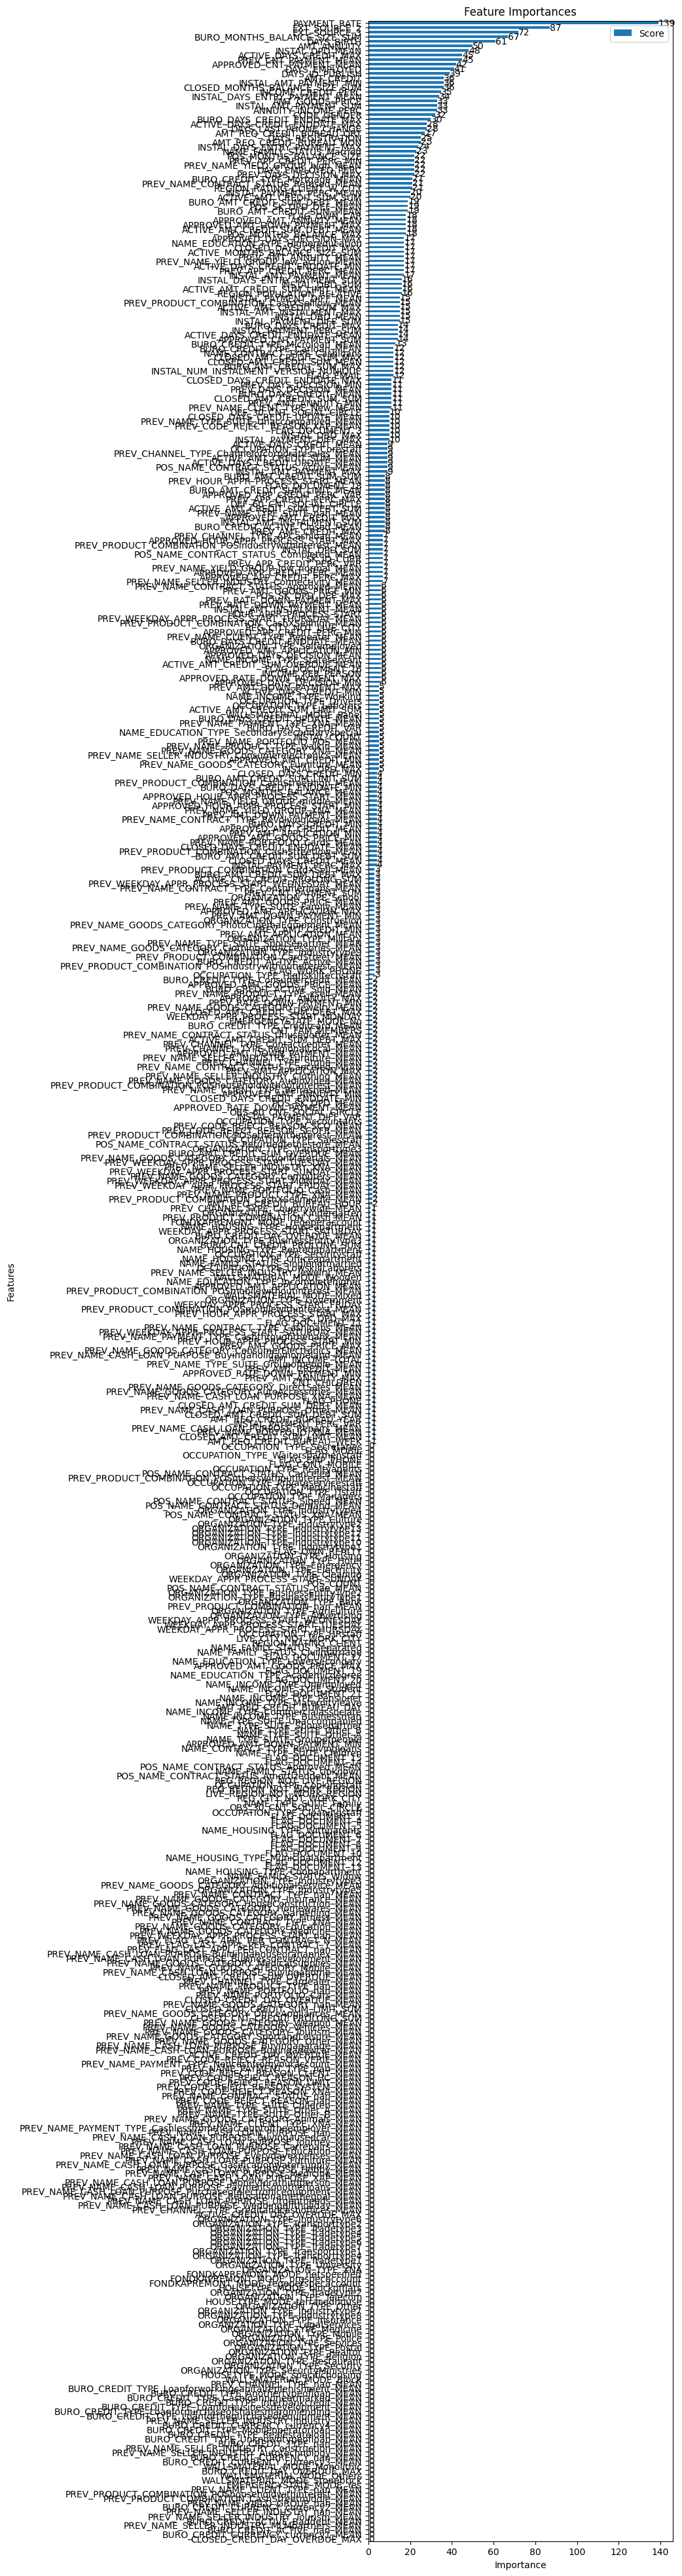

In [232]:
# Get the feature names from X (assuming X is a DataFrame)
feature_names = X.columns

# Create a DataFrame with the feature names and their importances
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Score': importances
})

# Sort the DataFrame by score
importances_df = importances_df.sort_values(by='Score', ascending=True)

# Plot the bar chart
ax = importances_df.plot.barh(x='Feature', y='Score', figsize=(6, 50))

# Add bar labels
ax.bar_label(ax.containers[0])

# # Rotate the y-axis labels if necessary (0 means no rotation)
# plt.yticks(rotation=0)  # Rotate y-axis labels to be horizontal

# # Adjust the layout to ensure everything fits properly
# plt.tight_layout()

# Show the plot
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

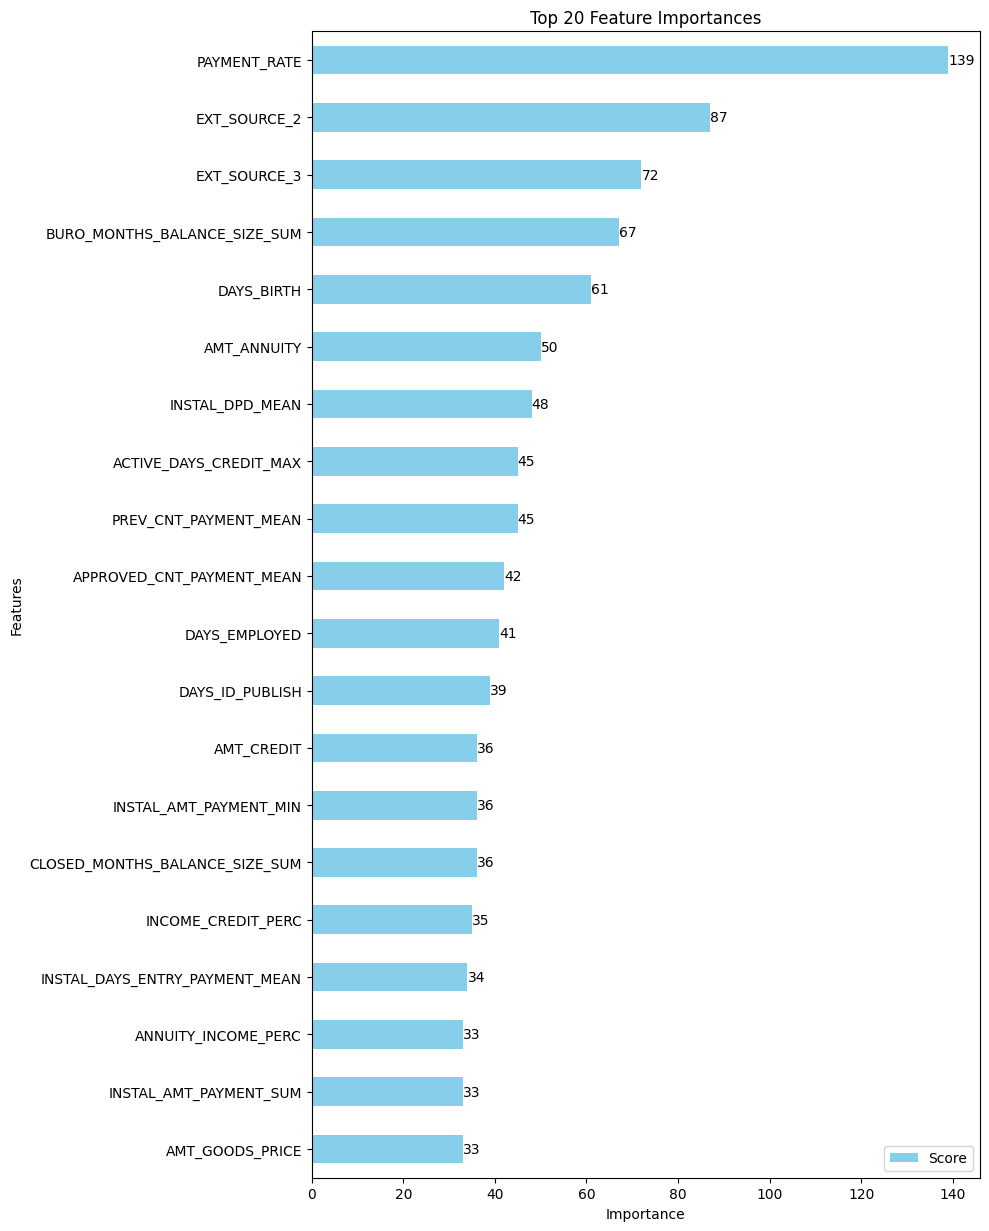

In [236]:
# Sort the DataFrame by score (importance) in descending order
importances_df = importances_df.sort_values(by='Score', ascending=False)

# Select the top 20 most important features
top_20_importances = importances_df.head(20)

# Plot the top 20 most important features with the largest at the top
ax = top_20_importances.plot.barh(x='Feature', y='Score', figsize=(10, 12), color='skyblue')  # Adjust the figure size

# Add bar labels
ax.bar_label(ax.containers[0])

# Rotate the y-axis labels for readability
plt.yticks(rotation=0)  # You can change the rotation if needed (e.g., 45 degrees)

# Reverse the y-axis to put the largest at the top
ax.invert_yaxis()

# Adjust the layout to ensure everything fits properly
plt.tight_layout()

# Show the plot
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()



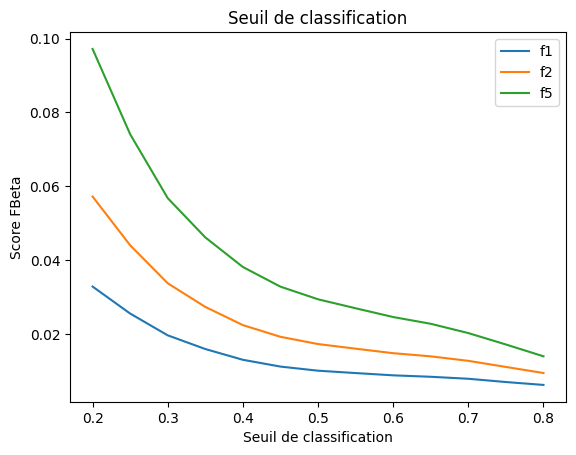

In [213]:
df_result = pd.concat((df_f1.mean(axis=1), df_f2.mean(axis=1), df_f5.mean(axis=1)), axis=1)
df_result.index=np.arange(0.2,0.8,0.05)
df_result.columns = ['f1', 'f2', 'f5']

df_result.plot(kind='line', xlabel='Seuil de classification', ylabel='Score FBeta', title='Seuil de classification')
plt.show()

Les concepts clés expliqués
a) Pipeline de traitement
Pipeline permet de chaîner plusieurs étapes de traitement (par exemple, normalisation et modélisation) dans une seule unité cohérente.
Avantage : Réduction du risque d'erreurs lors de la gestion des transformations séparément.
b) Gestion des données déséquilibrées
Dans des scénarios où une classe domine (par exemple, 95% de non-fraude, 5% de fraude), les modèles peuvent biaiser leurs prédictions vers la classe majoritaire.
RandomUnderSampler rééquilibre les classes en réduisant le nombre d'exemples de la classe majoritaire.
c) GridSearchCV
Permet d'automatiser l'optimisation d'hyperparamètres.
Utilise une validation croisée pour garantir la robustesse des performances.
d) Précision-Rappel et seuil optimal
Les courbes précision-rappel (PR) montrent la performance du modèle à différents seuils de classification.
Optimiser un seuil est crucial dans des contextes métiers où les coûts des erreurs varient.


Pourquoi ce code est utile
Flexibilité : Fonctionne avec n'importe quel modèle de classification.
Personnalisation : Permet d'adapter les métriques à des besoins métiers spécifiques.
Robustesse : Utilise des techniques comme la validation croisée et la journalisation pour garantir des résultats fiables.
Gestion des déséquilibres : Adapte les données pour mieux traiter les problèmes courants des classes rares.

### Récupérer le modèle LightGBM sans undersampling.
Appliquer la fonction predict_proba pour obtenir les probabilités des classes.
Varier le seuil de 0.2 à 0.8 avec un pas de 0.05.
Calculer le score métier pour chaque seuil.
Choisir le seuil avec le meilleur score métier.

In [117]:
X.shape

(291377, 551)

In [118]:
X.columns

Index(['SK_ID_CURR', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       ...
       'INSTAL_AMT_INSTALMENT_MEAN', 'INSTAL_AMT_INSTALMENT_SUM',
       'INSTAL_AMT_PAYMENT_MIN', 'INSTAL_AMT_PAYMENT_MAX',
       'INSTAL_AMT_PAYMENT_MEAN', 'INSTAL_AMT_PAYMENT_SUM',
       'INSTAL_DAYS_ENTRY_PAYMENT_MAX', 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN',
       'INSTAL_DAYS_ENTRY_PAYMENT_SUM', 'INSTAL_COUNT'],
      dtype='object', length=551)

In [119]:
X.head()

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
0,100002,0,0,0,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,11559.247070,2.196257e+05,9251.775391,53093.746094,11559.247070,2.196257e+05,-49.0,-315.421051,-5993.0,19.0
1,100003,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,64754.585938,1.618865e+06,6662.970215,560835.375000,64754.585938,1.618865e+06,-544.0,-1385.319946,-34633.0,25.0
2,100004,0,1,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,7096.154785,2.128846e+04,5357.250000,10573.964844,7096.154785,2.128846e+04,-727.0,-761.666687,-2285.0,3.0
3,100006,1,0,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,62947.089844,1.007153e+06,2482.919922,691786.875000,62947.089844,1.007153e+06,-12.0,-271.625000,-4346.0,16.0
4,100007,0,0,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,12666.444336,8.359853e+05,0.180000,22678.785156,12214.060547,8.061280e+05,-14.0,-1032.242432,-68128.0,66.0


In [120]:
y.head()

0    1.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: TARGET, dtype: float64

In [121]:
X_train.head()

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
151531,275645,0,0,0,0,180000.0,275040.0,13504.5,180000.0,0.008575,...,10420.304362,489754.305,223.065,21709.125,8999.263723,422965.395,-57.0,-821.063830,-38590.0,47.0
160424,285969,1,0,0,0,67500.0,305640.0,31446.0,270000.0,0.035792,...,17707.980000,159371.820,15987.915,31468.500,17707.980000,159371.820,-2353.0,-2498.888889,-22490.0,9.0
203849,336331,1,0,0,0,180000.0,270000.0,13500.0,270000.0,0.004960,...,21958.200000,109791.000,21958.200,21958.200,21958.200000,109791.000,-26.0,-88.600000,-443.0,5.0
300030,447581,1,1,1,0,135000.0,936018.0,30325.5,670500.0,0.019689,...,49064.877422,3140152.155,4898.835,239641.515,48638.972109,3112894.215,-28.0,-1027.796875,-65779.0,64.0
218527,353171,0,0,0,0,135000.0,343287.0,27121.5,310500.0,0.025164,...,16281.171667,439591.635,928.395,67500.000,16281.171667,439591.635,-23.0,-170.333333,-4599.0,27.0


In [122]:
y_train.head()

151531    0.0
160424    0.0
203849    0.0
300030    1.0
218527    0.0
Name: TARGET, dtype: float64

In [123]:
y.shape

(291377,)

### Seuil de classification pour meilleur modèle

In [124]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Fonction pour ajuster le seuil de classification
def tune_classification_threshold_lightgbm(model, X, y, scoring_function, thresholds=np.arange(0.2, 0.85, 0.05)):
    results = []
    y_proba = model.predict_proba(X)[:, 1]  # Probabilités de la classe positive

    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)  # Conversion en classes binaires
        print(y_proba, y_pred, threshold)
        print(scoring_function(y,y_pred))
        business_score = scoring_function(y, y_pred)  # Calcul du score métier 
        results.append({
            "Threshold": threshold,
            "Business Score": business_score
        })

    return pd.DataFrame(results)


# Division en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Renommer les colonnes pour éviter les conflits
X_train = pd.DataFrame(X_train, columns=[f"feature_{i}" for i in X_train.columns])
X_test = pd.DataFrame(X_test, columns=X_train.columns)

# Entraînement du modèle LightGBM
model = lgb.LGBMClassifier(random_state=42, num_leaves=31, learning_rate=0.1, n_estimators=100, max_depth=10)
# model.fit(X_train, y_train)
model.fit(np.array(X_train), np.array(y_train))

# Ajustement des seuils
threshold_results = tune_classification_threshold_lightgbm(
    model=model,
    X=X_test,
    y=y_test,
    scoring_function=business_score_metric
)

# Trouver le meilleur seuil
best_threshold = threshold_results.loc[threshold_results['Business Score'].idxmin()]
print(f"Meilleur seuil : {best_threshold['Threshold']} avec un Business Score de : {best_threshold['Business Score']}")


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 19048, number of negative: 214053
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 233101, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081716 -> initscore=-2.419262
[LightGBM] [Info] Start training from score -2.419262
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped trainin

In [125]:
threshold_results

,Threshold,Business Score
0,0.20,4826
1,0.25,4826
2,0.30,4826
3,0.35,4826
4,0.40,4826
5,0.45,4826
6,0.50,4826
7,0.55,4826
8,0.60,4826
9,0.65,4826


In [128]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

def tune_classification_threshold_lightgbm_cv(model, X, y, scoring_function, 
                                               thresholds=np.arange(0.2, 0.85, 0.05),
                                               cv=5):
    """
    Function to find the best classification threshold using cross-validation.

    Parameters:
    - model: The trained LightGBM model.
    - X: Features (DataFrame or ndarray).
    - y: Target variable (array-like).
    - scoring_function: Function to calculate the business score.
    - thresholds: Array of thresholds to evaluate.
    - cv: Number of cross-validation folds.

    Returns:
    - DataFrame containing thresholds and their corresponding mean business scores.
    """
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    results = []

    for threshold in thresholds:
        fold_scores = []
        for train_idx, val_idx in skf.split(X, y):
            #X_train_fold, X_val_fold = X[train_idx], X[val_idx]
            X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
            #y_train_fold, y_val_fold = y[train_idx], y[val_idx]
            y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]


            # Train the model on the fold
            model.fit(X_train_fold, y_train_fold)
            
            # Predict probabilities on the validation fold
            y_proba = model.predict_proba(X_val_fold)[:, 1]
            
            # Convert probabilities to binary predictions based on the threshold
            y_pred = (y_proba >= threshold).astype(int)
            
            # Calculate the business score for this fold
            fold_score = scoring_function(y_val_fold, y_pred)
            fold_scores.append(fold_score)

        # Calculate the mean score across folds for this threshold
        mean_score = np.mean(fold_scores)
        results.append({
            "Threshold": threshold,
            "Mean Business Score": mean_score
        })

    return pd.DataFrame(results)

# Example usage:
# Define a dummy scoring function for illustration
def business_score_metric(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp - fp  # Example business score: true positives minus false positives

# Assume X and y are already defined
# X = np.random.rand(1000, 10)  # Replace with actual data
# y = np.random.randint(0, 2, size=1000)  # Replace with actual labels

# Instantiate the LightGBM model
model = lgb.LGBMClassifier(random_state=42, num_leaves=31, learning_rate=0.1, 
                           n_estimators=100, max_depth=10)

# Nettoyer les noms de colonnes de X
if isinstance(X, pd.DataFrame):
    import re
    X.columns = [re.sub(r'[^\w]', '_', col) for col in X.columns]

# Vérifiez que cela fonctionne
print(X.columns)  # Les noms de colonnes devraient maintenant être sans caractères spéciaux


# Find the best threshold using cross-validation
threshold_results_cv = tune_classification_threshold_lightgbm_cv(
    model=model,
    X=X,
    y=y,
    scoring_function=business_score_metric
)

# Find the threshold with the highest mean business score
best_threshold_cv = threshold_results_cv.loc[threshold_results_cv['Mean Business Score'].idxmax()]
print(f"Best threshold: {best_threshold_cv['Threshold']} with a mean business score of: {best_threshold_cv['Mean Business Score']}")

Index(['SK_ID_CURR', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       ...
       'INSTAL_AMT_INSTALMENT_MEAN', 'INSTAL_AMT_INSTALMENT_SUM',
       'INSTAL_AMT_PAYMENT_MIN', 'INSTAL_AMT_PAYMENT_MAX',
       'INSTAL_AMT_PAYMENT_MEAN', 'INSTAL_AMT_PAYMENT_SUM',
       'INSTAL_DAYS_ENTRY_PAYMENT_MAX', 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN',
       'INSTAL_DAYS_ENTRY_PAYMENT_SUM', 'INSTAL_COUNT'],
      dtype='object', length=551)
[LightGBM] [Info] Number of positive: 19099, number of negative: 214002
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.098742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55848
[LightGBM] [Info] Number of data points in the train set: 233101, number of used features: 509
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081934 -> initscore=-2.416